# Introduction

we want to implement a model to optimize a current transportation network in a given city, we proposed a way to model the problem  and a squisite mathematical solution <br>
to see all the attached files and how we elaborated the aggregated additional data  check our github https://github.com/mnasini/wdl
reminder: since some of the asset are taken from our github repository open it wwith an internet connection, if you haven't, connect and simply refresh it !

# challenge development

first of we wanted to understand how the trandportation network of the cities was given.
lets first import the data and the libraries we are gonna use.

In [2]:
from typing import List
import random
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import graphviz

import os
from IPython.display import Image, display
from graphviz import Source

In [3]:
df_routes = pd.read_csv('data/BusRoutes.txt', encoding= 'unicode_escape',sep="|")
df_senior = pd.read_csv('data/Senior_TIM_v1.txt', encoding= 'unicode_escape',sep="|")

In [4]:
df_routes.head()

,IDRoute,linkid
0,1,537277300
1,1,537277673
2,1,537277754
3,1,537277777
4,1,537277795


as is possible to see in the dataset df_routes() are present 2 features:
- IDRoute   is the bus line
- linkid    is the road segment 

and the second dataset:

In [5]:
df_senior.head()

,linkid,Region_of_Origin,District_of_Origin,County_of_Origin,Average_Daily_SeniorPopulation_Travelling
0,80216810,R1 - AM Lisboa,Lisboa,Lisboa,2013.681187
1,80216810,R1 - AM Lisboa,Setúbal,Palmela,7688.296396
2,80216810,R1 - AM Lisboa,Lisboa,Oeiras,220.647248
3,80216810,R1 - AM Lisboa,Lisboa,Vila Franca de Xira,233.203075
4,80216812,R1 - AM Lisboa,Lisboa,Lisboa,261.606014


this dataset represent the movements of the senior population:
- linkid is the road segment 
- Region_of_Origin, District_of_Origin, County_of_Origin represents their origin
- Average_Daily_SeniorPopulation_Travelling represents the number of old people that passes through the road segments

in this part we aim to understand the current mobility patterns of the senior population with the current public transportation network.

# data visualization

the first task we did is understanding the geographic position of the linkids.
To do so, we used the HERE Fleet Telematics API (Advanced Datasets), that according to PSE was computed using the same service.
We therefore  obtained for each linkid a tile that contains the road link in analysis, so for each linkid we were able to approximate  it's geographic position using the mercator coordinate system.

secondly we grouped both dataset via the new coordinates we got.<br>
In this way we were able to identify the bus routes passing in each tile, we then exported the resulting dataset in csv to include it in this solution, just to not overcomplicate our code :) 

In [6]:
df = pd.read_csv("coords_senior_data.csv", sep="|")
df.tail()

,x,y,avg_senior,bus_routes
946,7817,5958,288.942826,[]
947,7818,5960,115.577130,[]
948,7819,5959,346.731390,[]
949,7819,5960,693.462780,[]
950,7819,5961,115.577130,[]


as is possible to see at a first glance there are positions that has presence of seniors travelling and no bus routes

we are so able to buid a heatmap of the current public transportation coverage, and compare it with the movements of the senior population

In [7]:
max_x = max(df.x)+1
max_y = max(df.y)+1

heatmap_buses = np.zeros((max_x, max_y))
heatmap_seniors = np.zeros((max_x, max_y))

for t in df.itertuples():
    heatmap_buses[t.x, t.y] = len(eval(t.bus_routes))
    heatmap_seniors[t.x, t.y] = t.avg_senior

heatmap_seniors /= heatmap_seniors.max()/255.0   #the 2 scaled matrices 
heatmap_buses /= heatmap_buses.max()/255.0



now we plot them:

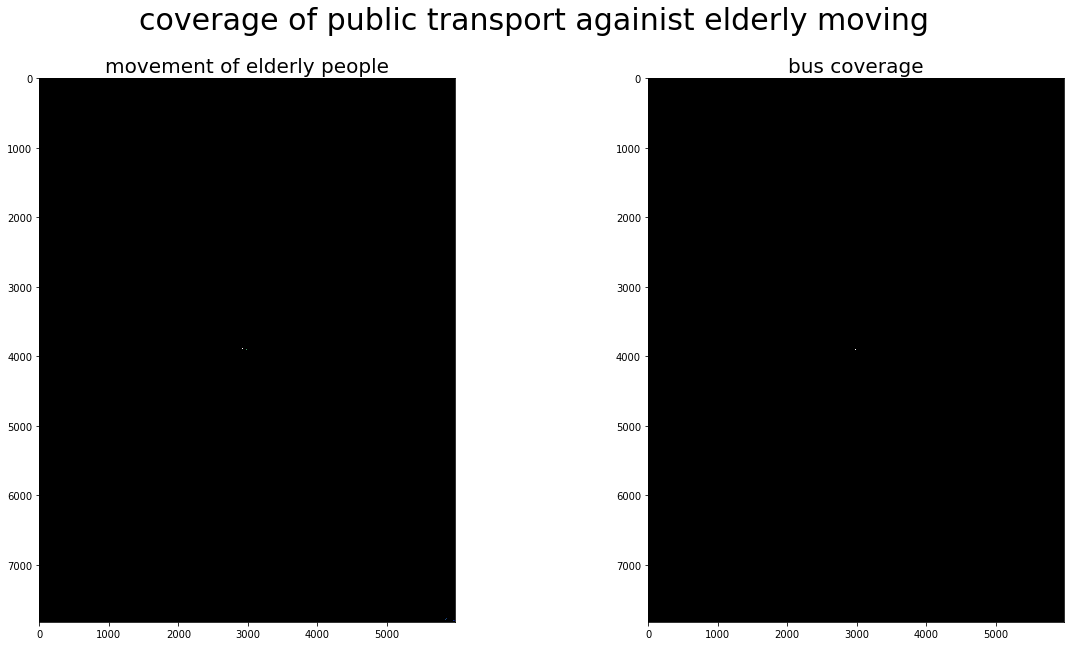

In [8]:
from PIL import Image
from matplotlib import cm

im_senior = Image.fromarray(np.uint8(cm.gist_earth(heatmap_seniors)*255))
im_buses = Image.fromarray(np.uint8(cm.gist_earth(heatmap_buses)*255))
figure, (ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
figure.suptitle('coverage of public transport againist elderly moving').set_size(30)
ax1.set_title('movement of elderly people').set_size(20)
ax2.set_title('bus coverage').set_size(20)
ax1.imshow(im_senior, cmap='hot', interpolation='nearest')

ax2.imshow(im_buses, cmap='hot', interpolation='nearest')
im_senior.save("heatmap_senior.png")
im_buses.save("heatmap_buses.png")  

![title](https://raw.githubusercontent.com/mnasini/wdl/master/heatmap_seniors.png)

as you can see it generates black image, thats only because each tile has a surface area of 90 square kilometers and when  you zoom the generated picture , we can clearly see that there are 4 cities.(center and bottom right).
lets crop it and focus on one city

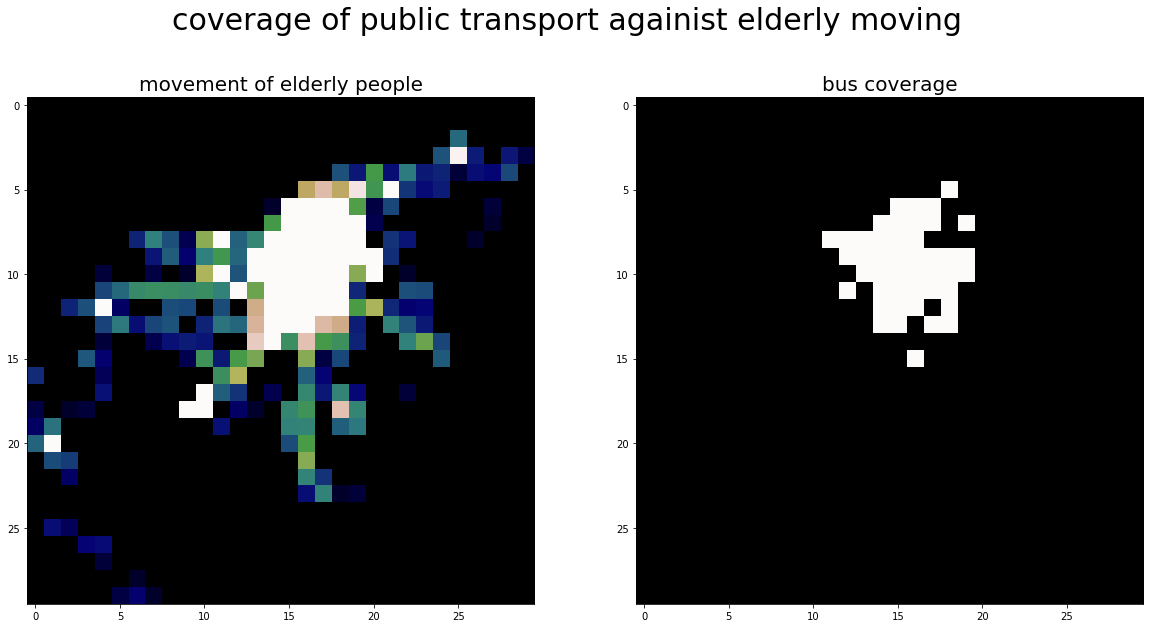

In [9]:
heatmap_seniors_subset=heatmap_seniors[-30:,-30:]
heatmap_buses_subset=heatmap_buses[-30:,-30:]
heatmap_seniors_subset /= heatmap_seniors_subset.max()/255.0
heatmap_buses_subset /= heatmap_buses_subset.max()/255.0

im_senior_crop = Image.fromarray(np.uint8(cm.gist_earth(heatmap_seniors_subset)*255))
im_buses_crop = Image.fromarray(np.uint8(cm.gist_earth(heatmap_buses_subset)*255))

figure, (ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
figure.suptitle('coverage of public transport againist elderly moving').set_size(30)
ax1.set_title('movement of elderly people').set_size(20)
ax2.set_title('bus coverage').set_size(20)
ax1.imshow(im_senior_crop, cmap='hot', interpolation='nearest')
ax2.imshow(im_buses_crop, cmap='hot', interpolation='nearest')



as is possible to see from those tilemaps( that are geographically accurate)  that the coverage of the bus network is very concentrated in the city center.
if we compare  the 2 pictures we can also see some inefficiencies(movements of  elderly people in zones not covered by the bus lines (the scale of the two picture is the same).<br>
For example at a first glance we wanted to introduce an entire new busline on the bottom left of the picture.

# modelling

the heatmap is a great solution to understand if there are inefficiencies in the current public transportation network, but wont tell us much of the movement of elderly people within the network.
We can model the public transportation network as a graph in with each node is a road link(linkid) and each edge is a bus line, so if 2 roadlinks are connected with the same IDRoute will have also an edge that connect them.
each node has an attribute of the aggregated  number of elderly people passing trough them, this will be useful for plotting the dimension of the node


we now see an example plotting  only the first 3 lines

In [10]:
G = nx.MultiGraph()

In [11]:
df_loc = pd.read_csv("geospatial_data.csv") #our geospatial data 


lets create a function to connect the nodes using networkx

In [12]:
def connect_routes(lab, lst, g: nx.MultiGraph):
    links = list(lst.linkid)
    if len(links) == 0:
        return
    for i in range(len(links)-1):
        conn = g.edges.get((links[i], links[i+1], 0))
        if conn is None or conn['label'] != lab.iloc[0]:
            g.add_edge(links[i], links[i+1], label=lab.iloc[0])

lets create another function now to sort distances

In [13]:
def sort_distances(df):
    subset=df[['linkid','x', 'y']]
    l = list(subset.itertuples(index=False,name=None))
    p=l[0]
    
    
    sorted_locations = []
    for i in range(len(l)):
          
        dist= pow((p[1] - l[i][1]), 2)+ pow((p[2] - l[i][2]), 2)
          
        sorted_locations.append([dist,[l[i][0],l[i][1],l[i][2]]])
          
    sorted_locations.sort()
    
    return list(map(lambda x: x[1][0],sorted_locations))

lets build the graph

In [14]:
df_routes=df_routes.set_index('IDRoute').loc[1:3].reset_index() 
df_routes=df_routes.rename_axis(None)
df_aggreg=df_senior.groupby('linkid').apply(sum).drop(columns=['Region_of_Origin', 'District_of_Origin','County_of_Origin'])
df_aggreg=df_aggreg.rename_axis(None)
df_routes=df_routes.merge(df_aggreg,how='left',left_on='linkid',right_on='linkid')
df_routes=df_routes.merge(df_loc,how='left',left_on='linkid',right_on='linkid')
nod=sort_distances(df_routes) 
G.add_nodes_from(nod)
node_attrib=df_routes.groupby('linkid')['Average_Daily_SeniorPopulation_Travelling'].apply(sum)
nx.set_node_attributes(G, node_attrib,'elderly')
df_routes.groupby('IDRoute').apply(lambda x: connect_routes(x['IDRoute'], x, G)) #each group is composed by sorted via location
                                                                                #linkids that belongs to the same line

""


each node has right now as an attribute the number of elderly  people passing trough them and as edge attribute, the corresponding line(the graph will have multiple parallel edges if two busses connects the same road segments

each node with the number of elderly peoples passingh trough them:

In [15]:
nx.get_node_attributes(G, 'elderly')

{537277300: 0.0,
 537282528: 0.0,
 811954394: 88.905485,
 811954396: 88.905485,
 811957840: 0.0,
 901326578: 0.0,
 1101648083: 88.905485,
 1160927171: 0.0,
 1160927529: 0.0,
 1223142710: 0.0,
 537277754: 0.0,
 537277795: 0.0,
 537278408: 0.0,
 537278623: 0.0,
 537278860: 0.0,
 537279035: 0.0,
 537279154: 0.0,
 537279247: 0.0,
 811401336: 0.0,
 811401337: 0.0,
 811401512: 0.0,
 811463684: 0.0,
 811463685: 0.0,
 811463686: 204.05269099999998,
 811463687: 0.0,
 811469801: 0.0,
 811471524: 2065.6493379999997,
 811471525: 0.0,
 811471526: 0.0,
 811477414: 0.0,
 811477415: 0.0,
 811480959: 0.0,
 811639528: 0.0,
 811639529: 0.0,
 811639530: 0.0,
 811639531: 0.0,
 811639532: 0.0,
 812132634: 0.0,
 812144373: 0.0,
 812144374: 0.0,
 812144375: 204.05269099999998,
 812224197: 0.0,
 537277673: 0.0,
 537277777: 0.0,
 537283957: 0.0,
 537284163: 85.916922,
 593892423: 0.0,
 721545568: 0.0,
 721545569: 0.0,
 746670115: 0.0,
 799427718: 204.05269099999998,
 799481022: 0.0,
 799481023: 2173.464878,
 79

each edge:

In [16]:
nx.get_edge_attributes(G, 'label')

{(537277300, 537277673, 0): 1,
 (537282528, 537279035, 0): 1,
 (537282528, 537283957, 0): 1,
 (811954394, 811639532, 0): 1,
 (811954394, 811954396, 0): 1,
 (811954396, 811957840, 0): 1,
 (811957840, 811959963, 0): 1,
 (901326578, 901324170, 0): 1,
 (901326578, 901326581, 0): 1,
 (1101648083, 901326585, 0): 1,
 (1101648083, 1160927171, 0): 1,
 (1160927171, 1160927529, 0): 1,
 (1160927529, 1160928185, 0): 1,
 (1223142710, 1202673585, 0): 1,
 (1223142710, 1246604405, 0): 1,
 (537277754, 537277673, 0): 1,
 (537277754, 537277777, 0): 1,
 (537277795, 537277777, 0): 1,
 (537277795, 537277954, 0): 1,
 (537278408, 537277980, 0): 1,
 (537278408, 537277980, 1): 2,
 (537278408, 537278623, 0): 1,
 (537278408, 537278623, 1): 2,
 (537278623, 537278860, 0): 1,
 (537278623, 537278860, 1): 2,
 (537278860, 537279035, 0): 1,
 (537278860, 537279154, 0): 2,
 (537279154, 537279193, 0): 2,
 (537279247, 537279193, 0): 2,
 (537279247, 537280111, 0): 2,
 (811401336, 811398831, 0): 1,
 (811401336, 811401337, 0): 

## graph optimisation

since each node is a road link, the graph will be very big, and it will be really difficult to learn someting insightful from it. so we wanted to optimise it.

to do so we removed all the nodes that have the same parent bus lines entering and the same child bus line exiting that do not present a significant variation over the parent line and the child line, in this way we are left only with nodes that have a bus stop inside, from with we can understang the variation of the flow of elderly peoples within the city

![title](https://raw.githubusercontent.com/mnasini/wdl/master/avg.png)

lets now present the code:

here is the function that remove the useless node to simplify the graph

In [17]:
def rem(g: nx.MultiGraph) -> None:
    node_attributes=nx.get_node_attributes(G,'elderly')
    nodes = list(g.nodes)
    for node in nodes:
        neigh=list(g.neighbors(node))
        
        if len(neigh) == 2 and (g.degree(node) % 2) == 0:
            try:
                set1 = {edge['label'] for edge in g.get_edge_data(node, neigh[0]).values()}
            except:
                print(g.get_edge_data(node, neigh[0]))
            set2 = {edge['label'] for edge in g.get_edge_data(node, neigh[1]).values()}
            if set1 == set2:
                succ=node_attributes[neigh[1]]+0.001
                node_attr=node_attributes[node]+0.001
                if (abs((node_attr-succ))<1000):
                    g.remove_node(node)
                    for edge_label in set1: 
                        g.add_edge(neigh[0], neigh[1], label=edge_label)

In [18]:
for i in range(5):
    rem(G)

## plotting the graph:

to plot this graph we converted it in pydot format that will be perfect for future visualisation of more lines since the generated image is vectorial and do not lose definition when you zoom it

In [19]:
p=nx.drawing.nx_pydot.to_pydot(G)

we define a new function to color the lines, this function generates 180 random colors that will be to be used to color each line 

In [20]:
def color_list():
    rand=[random.randint(0,16777215) for i in range(180)]
    hexrand=list(map(str,list(map(hex,rand))))
    hexrand=list(map(lambda x: '#'+ x[2:],hexrand))
    return hexrand

we color each line:

In [21]:
colors=color_list()
for i, edge in enumerate(p.get_edges()):
    edge.set_color(colors[int(edge.get("label"))])

we set the dimension of ech node based of the number of elderly people passing trough it

In [22]:
map_weight=dict(zip(nx.get_node_attributes(G,'elderly').keys(),map(lambda x: (((x - 0) / (2000-0)) * (1-0.2) + 0.2)+1,nx.get_node_attributes(G,'elderly').values())))
for i, node in enumerate(p.get_nodes()):
    node.set_height(str(map_weight[int(node.get_name())]))
    node.set_width(str(map_weight[int(node.get_name())]))

In [23]:

p.write_png('multi1.png')


### here is the full code:

In [24]:
def connect_routes(lab, lst, g: nx.MultiGraph):
    links = list(lst.linkid)
    if len(links) == 0:
        return
    for i in range(len(links)-1):
        conn = g.edges.get((links[i], links[i+1], 0))
        if conn is None or conn['label'] != lab.iloc[0]:
            g.add_edge(links[i], links[i+1], label=lab.iloc[0])

def rem(g: nx.MultiGraph) -> None:
    node_attributes=nx.get_node_attributes(G,'elderly')
    nodes = list(g.nodes)
    for node in nodes:
        neigh=list(g.neighbors(node))
        
        if len(neigh) == 2 and (g.degree(node) % 2) == 0:
            try:
                set1 = {edge['label'] for edge in g.get_edge_data(node, neigh[0]).values()}
            except:
                print(g.get_edge_data(node, neigh[0]))
            set2 = {edge['label'] for edge in g.get_edge_data(node, neigh[1]).values()}
            if set1 == set2:
                #prec=node_attributes[neigh[0]]+0.001
                succ=node_attributes[neigh[1]]+0.001
                node_attr=node_attributes[node]+0.001
               # if (abs((node_attr-prec))<1000) and (abs((node_attr-succ))<1000):
                if (abs((node_attr-succ))<1000):
                    g.remove_node(node)
                    for edge_label in set1: 
                        g.add_edge(neigh[0], neigh[1], label=edge_label)
                        

def sort_distances(df):
    subset=df[['linkid','x', 'y']]
    l = list(subset.itertuples(index=False,name=None))
    p=l[0]
    
    
    sorted_locations = []
    for i in range(len(l)):
          
        dist= pow((p[1] - l[i][1]), 2)+ pow((p[2] - l[i][2]), 2)
          
        sorted_locations.append([dist,[l[i][0],l[i][1],l[i][2]]])
          
    sorted_locations.sort()
    
    return list(map(lambda x: x[1][0],sorted_locations))

G = nx.MultiGraph()
pos = nx.spring_layout(G)
df_routes = pd.read_csv('data/BusRoutes.txt', encoding= 'unicode_escape',sep="|")
df_senior = pd.read_csv('data/Senior_TIM_v1.txt', encoding= 'unicode_escape',sep="|")
df_loc = pd.read_csv("geospatial_data.csv")


df_routes=df_routes.set_index('IDRoute').loc[1:3].reset_index()
df_routes=df_routes.rename_axis(None)
df_aggreg=df_senior.groupby('linkid').apply(sum).drop(columns=['Region_of_Origin', 'District_of_Origin','County_of_Origin'])
df_aggreg=df_aggreg.rename_axis(None)
df_routes=df_routes.merge(df_aggreg,how='left',left_on='linkid',right_on='linkid')
df_routes=df_routes.merge(df_loc,how='left',left_on='linkid',right_on='linkid')
nod=sort_distances(df_routes)

G.add_nodes_from(nod)
node_attrib=df_routes.groupby('linkid')['Average_Daily_SeniorPopulation_Travelling'].apply(sum)
nx.set_node_attributes(G, node_attrib,'elderly')
df_routes.groupby('IDRoute').apply(lambda x: connect_routes(x['IDRoute'], x, G))

for i in range(5):
    rem(G)


def color_list():
    rand=[random.randint(0,16777215) for i in range(90)]
    hexrand=list(map(str,list(map(hex,rand))))
    hexrand=list(map(lambda x: '#'+ x[2:],hexrand))
    return hexrand



p=nx.drawing.nx_pydot.to_pydot(G)


colors=color_list()
for i, edge in enumerate(p.get_edges()):
    edge.set_color(colors[int(edge.get("label"))])


map_weight=dict(zip(nx.get_node_attributes(G,'elderly').keys(),map(lambda x: (((x - 0) / (2000-0)) * (1-0.2) + 0.2)+1,nx.get_node_attributes(G,'elderly').values())))
for i, node in enumerate(p.get_nodes()):
    node.set_height(str(map_weight[int(node.get_name())]))
    node.set_width(str(map_weight[int(node.get_name())]))

p.write_png('multi1.png')


![title](https://raw.githubusercontent.com/mnasini/wdl/master/multi1.png)

we can see the flow of people of the first 3 lines, along with each node connection, keep in mind this graph is not completely correct because in order of getting a simpler result to plot we only showed the simplified model of 3 lines 

# public trasportation network of the city in analysis

right now that we know how to model the current transportation network, the flow of elderly people, and how to check for inefficiencies we can try to get real. 

lets rewrite the code to plot all the real bus network of the city in analysis:

In [25]:
def connect_routes(lab, lst, g: nx.MultiGraph):
    links = list(lst.linkid)
    if len(links) == 0:
        return
    for i in range(len(links)-1):
        conn = g.edges.get((links[i], links[i+1], 0))
        if conn is None or conn['label'] != lab.iloc[0]:
            g.add_edge(links[i], links[i+1], label=lab.iloc[0])

def rem(g: nx.MultiGraph) -> None:
    node_attributes=nx.get_node_attributes(G,'elderly')
    nodes = list(g.nodes)
    for node in nodes:
        neigh=list(g.neighbors(node))
        
        if len(neigh) == 2 and (g.degree(node) % 2) == 0:
            try:
                set1 = {edge['label'] for edge in g.get_edge_data(node, neigh[0]).values()}
            except:
                print(g.get_edge_data(node, neigh[0]))
            set2 = {edge['label'] for edge in g.get_edge_data(node, neigh[1]).values()}
            if set1 == set2:
                #prec=node_attributes[neigh[0]]+0.001
                succ=node_attributes[neigh[1]]+0.001
                node_attr=node_attributes[node]+0.001
               # if (abs((node_attr-prec))<1000) and (abs((node_attr-succ))<1000):
                if (abs((node_attr-succ))<1000):
                    g.remove_node(node)
                    for edge_label in set1: 
                        g.add_edge(neigh[0], neigh[1], label=edge_label)
                        

def sort_distances(df):
    subset=df[['linkid','x', 'y']]
    l = list(subset.itertuples(index=False,name=None))
    p=l[0]
    
    
    sorted_locations = []
    for i in range(len(l)):
          
        dist= pow((p[1] - l[i][1]), 2)+ pow((p[2] - l[i][2]), 2)
          
        sorted_locations.append([dist,[l[i][0],l[i][1],l[i][2]]])
          
    sorted_locations.sort()
    
    return list(map(lambda x: x[1][0],sorted_locations))

G = nx.MultiGraph()
df_routes = pd.read_csv('data/BusRoutes.txt', encoding= 'unicode_escape',sep="|")
df_senior = pd.read_csv('data/Senior_TIM_v1.txt', encoding= 'unicode_escape',sep="|")
df_loc = pd.read_csv("geospatial_data.csv")



df_aggreg=df_senior.groupby('linkid').apply(sum).drop(columns=['Region_of_Origin', 'District_of_Origin','County_of_Origin'])
df_aggreg=df_aggreg.rename_axis(None)
df_routes=df_routes.merge(df_aggreg,how='left',left_on='linkid',right_on='linkid')
df_routes=df_routes.merge(df_loc,how='left',left_on='linkid',right_on='linkid')
df_routes=df_routes[(df_routes.x>=7769)&(df_routes.y>=5933)]
nod=sort_distances(df_routes)

nod=sort_distances(df_routes)

G.add_nodes_from(nod)
node_attrib=df_routes.groupby('linkid')['Average_Daily_SeniorPopulation_Travelling'].apply(sum)
nx.set_node_attributes(G, node_attrib,'elderly')
df_routes.groupby('IDRoute').apply(lambda x: connect_routes(x['IDRoute'], x, G))


for i in range(5):
    rem(G)



def color_list():
    rand=[random.randint(0,16777215) for i in range(200)]
    hexrand=list(map(str,list(map(hex,rand))))
    hexrand=list(map(lambda x: '#'+ x[2:],hexrand))
    return hexrand



p=nx.drawing.nx_pydot.to_pydot(G)


colors=color_list()
for i, edge in enumerate(p.get_edges()):
    edge.set_color(colors[int(edge.get("label"))])


map_weight=dict(zip(nx.get_node_attributes(G,'elderly').keys(),map(lambda x: (((x - 0) / (2000-0)) * (1-0.2) + 0.2)+1,nx.get_node_attributes(G,'elderly').values())))
for i, node in enumerate(p.get_nodes()):
    node.set_height(str(map_weight[int(node.get_name())]))
    node.set_width(str(map_weight[int(node.get_name())]))



    
    
    
p.write_png('multi.png')


the generated picture is very big(over 10 mb) this is because when we scale to a real city the network representation becomes very complicated, to show it we cropped the image in some interesting points:

![title](https://raw.githubusercontent.com/mnasini/wdl/master/multi_crop1.PNG)

here zoomed a bit

![title](https://raw.githubusercontent.com/mnasini/wdl/master/multi_crop_2.PNG)

here zoomed again

![title](https://github.com/mnasini/wdl/raw/master/multi_cropped3.PNG)

for the full picture check our github https://github.com/mnasini/wdl/blob/master/multi.png 

as you can see there are some roadnodes with a lot of bus lines passing trought them, but with very few elderly people, and some nodes full of seniors but with a very little amount of lines passing trough them 

# our solution 

we have right now a matrix that contains a frequence of the coverage of public transport in the city, a matrix that represents the frequence of elderly people par tile, so we can model it as an optimisation problem, in wich the value is represented by the number of elderly people present in for each tile, and the cost is the current number of lines passing for the tile analysed

so our problem could be written as 
maximise $\sum_{i=0}^{n-1} x_{i}v_{i}$ constrained to: $\sum_{i=0}^{n-1} x_{i}w_{i}<m$ \\
so we need to find the best binary vector $x$(each element is 1 if we want create new routes in that zone, 0 otherwise)
<br> We implemented the cost function as this:

 $-\sum_{i=0}^{n-1} x_{i}v_{i}+k\Theta((\sum_{i=0}^{n-1} x_{i}w_{i})-m)$
the $\Theta$ function ensures that if we are below the limit we don't pay any cost, if we are above we pay a cost proportional to the exceeding part.
so summarizing $\Theta$ is 0 if $\sum_{i=0}^{n-1} x_{i}w_{i}-m\leq0$ and  $\sum_{i=0}^{n-1} x_{i}w_{i}$  if $\sum_{i=0}^{n-1} x_{i}w_{i}-m>0$ \\

the $m$ value represents our maximal costs, namely the value of the maximal normalised budget that the city wants to spend to optimise the public transport nework for elderly people 

this is a very known problem in computer science and algorithm analysis, is called knapsack problems, and if we solve it with dynamic programming we are sure to converge in an optimal solution of x. 
this vector x is really important, because it gives us informations about each tile(location) to be optimised to maximize the social effect on elderly people, moreover it is also feasible in a real world environment because very often cities have limited resources, and we wanted to find a solution that complied with the current situation.

first of all we ger our values an our costs

In [25]:
heatmap_buses = np.zeros((max_x, max_y))
heatmap_seniors = np.zeros((max_x, max_y))

for t in df.itertuples():
    heatmap_buses[t.x, t.y] = len(eval(t.bus_routes))
    heatmap_seniors[t.x, t.y] = t.avg_senior

a=[]
for i in range(0,np.shape(heatmap_buses)[0]):
    for g in range(0,np.shape(heatmap_buses)[1]):
       a.append((i,g))
    

            
       



[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 14),
 (0, 15),
 (0, 16),
 (0, 17),
 (0, 18),
 (0, 19),
 (0, 20),
 (0, 21),
 (0, 22),
 (0, 23),
 (0, 24),
 (0, 25),
 (0, 26),
 (0, 27),
 (0, 28),
 (0, 29),
 (0, 30),
 (0, 31),
 (0, 32),
 (0, 33),
 (0, 34),
 (0, 35),
 (0, 36),
 (0, 37),
 (0, 38),
 (0, 39),
 (0, 40),
 (0, 41),
 (0, 42),
 (0, 43),
 (0, 44),
 (0, 45),
 (0, 46),
 (0, 47),
 (0, 48),
 (0, 49),
 (0, 50),
 (0, 51),
 (0, 52),
 (0, 53),
 (0, 54),
 (0, 55),
 (0, 56),
 (0, 57),
 (0, 58),
 (0, 59),
 (0, 60),
 (0, 61),
 (0, 62),
 (0, 63),
 (0, 64),
 (0, 65),
 (0, 66),
 (0, 67),
 (0, 68),
 (0, 69),
 (0, 70),
 (0, 71),
 (0, 72),
 (0, 73),
 (0, 74),
 (0, 75),
 (0, 76),
 (0, 77),
 (0, 78),
 (0, 79),
 (0, 80),
 (0, 81),
 (0, 82),
 (0, 83),
 (0, 84),
 (0, 85),
 (0, 86),
 (0, 87),
 (0, 88),
 (0, 89),
 (0, 90),
 (0, 91),
 (0, 92),
 (0, 93),
 (0, 94),
 (0, 95),
 (0, 96),
 (0, 97),
 (0, 98),
 (0, 99),
 (0, 100),

In [36]:
costs=heatmap_buses.flatten(order='C')
values=heatmap_seniors.flatten(order='C')

then we assume a maximal costs we can have of 200 , namely we are able to select  coordinates that need rerouting with a maximum number of lines passing trough them of 200

In [37]:
maxc=200

then we write a simple dynamic programming solution to solve this problem 

In [41]:
def opti_tiles(value, weights, W):
    
    n=len(value)
   
    K = [[0 for x in range(W + 1)] for x in range(n + 1)] 
    trace=[[0 for x in range(W + 1)] for x in range(n + 1)] 
    chosen_items = []

    for i in range(n + 1): 
      for w in range(W + 1): 
            if i == 0 or w == 0: 
                K[i][w] = 0
            elif weights[i-1] <= w: 
                K[i][w] = max(value[i-1]+ K[i-1][w-weights[i-1]],  K[i-1][w])
                if K[i][w]==value[i-1]+ K[i-1][w-weights[i-1]]:
                   trace[i][w]=1
            else: 
                K[i][w] = K[i-1][w] 
    i=n
    w=W
           
    while i!=0:
        if trace[i][w]==1:
           chosen_items.append(i-1)
           w=w-weights[i-1]
           i=i-1
        else:
           i=i-1
    
   
    
    return chosen_items[::-1]


In [ ]:
opti_tiles=opti_tiles(values,costs,maxc)

now opti_tiles contains the positions relative to the vector of coordinates (a) of the x and y that represents our coordinates of  tiles(they all have the same zoom level), so we know the exact matematicl position in the city that needs at most (depending on maximal cost we are given ) to be optimised

# is always rerouting:

once we have a vector that represents the location of each zone that needs coverage we want to use the information we have from the graph to compute the optimal rerouting, to do so we wanted to locate the linkids that do not have lines passing trought them and the linkids, and for each of those, we identify the line and the linkid that has the direct connection to the nearest tile, and we let it pass also trought the selected node,rerouting the edge in question.<br>
In this way we have actively selected the cheapest line to reroute that have the highests social impact 

# conclusions

we presented a way to optimise the public transport network in of a city in an elegant mathematical way, elegedly identifing inefficiencies and traffic flows, our solutions uses a completely scalable polynomial algorithm (knapsack with dynamic programming) that is effectively scalable to any given dimensions, this solution is also feasible in a current real business environment, because it takes in consideration also the limitations of resources  of the current environment.
This solution could be a game changer for optimising public transports because is fast, cheap and understandable by everyone, it can be applied not only to public trasportation, but also to transportation in general. 
Is a general solution for optimising transportation in a city. <br> 

## future development

this model optimise transports for only a class of citizens in the city, it would be better to see to what extend of optimality is the current public transportation network to every class of citizen, to do so we only need to have a budget level and the datas also for the other classes, with it , we can still apply our solution, since the degree of scalability is almost infinite.